In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("clean_amazon.csv")
df.head()

,Unnamed: 0,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,161427,0.563,0.184,-13.757,0.0512,0.993,0.000016,0.325,0.654,133.088
1,1,223440,0.427,0.180,-15.375,0.0670,0.989,0.000000,0.128,0.431,78.459
2,2,208267,0.511,0.206,-15.514,0.0592,0.995,0.000000,0.418,0.481,70.443
3,3,161933,0.676,0.467,-12.393,0.1650,0.991,0.000000,0.219,0.726,129.775
4,4,167973,0.650,0.298,-13.806,0.1380,0.991,0.000000,0.373,0.844,75.950


In [3]:

df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.columns

Index(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

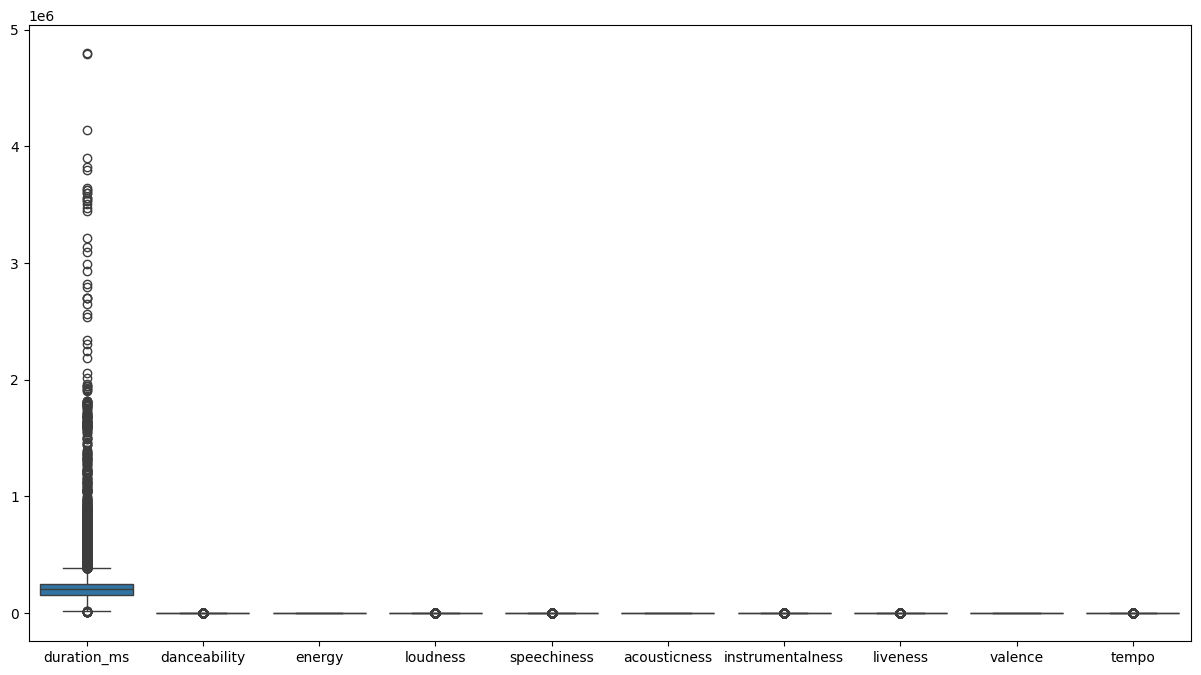

In [5]:
features = ["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]
plt.figure(figsize=(15,8))
sns.boxplot(data=df[features])
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
x_capped = df.copy()
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x_capped)

In [8]:
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x_capped)

In [9]:
#elbow method
from sklearn.cluster import KMeans
inertia=[]
k_range=range(2,11)
for k in k_range:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

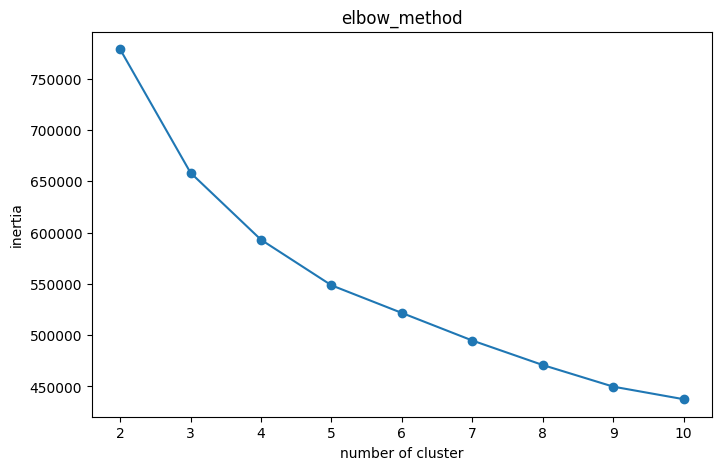

In [10]:
plt.figure(figsize=(8,5))
plt.plot(k_range,inertia,marker="o")
plt.xlabel("number of cluster")
plt.ylabel("inertia")
plt.title("elbow_method")
plt.show()

elbow method showing the k =3 or 4 or 5

In [12]:
from sklearn.metrics import silhouette_score

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    print(f"k = {k}, Silhouette Score = {score:.3f}")


k = 2, Silhouette Score = 0.203
k = 3, Silhouette Score = 0.242
k = 4, Silhouette Score = 0.231
k = 5, Silhouette Score = 0.186
k = 6, Silhouette Score = 0.186
k = 7, Silhouette Score = 0.165


In [11]:
kmeans=KMeans(n_clusters=4,random_state=42)
df["clusters"]=kmeans.fit_predict(x_scaled)

In [16]:
from sklearn.metrics import silhouette_score
sil_score=silhouette_score(x_scaled,df["clusters"])
sil_score


0.2310664126447332

In [12]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(x_scaled,df["clusters"])
db_score


1.5296828507168276

for k= 2 DB score= 1.9354533976929835 >1.5

for k= 3 DB score= 1.5699416879877053 >1.5

for k= 4 DB score= 1.5296828507168276 best choise

for k= 5 DB score= 1.6886165062636276 >1.5

In [13]:
df["clusters"].value_counts(normalize=True) * 100

clusters
1    48.398844
3    30.446487
2    12.948026
0     8.206643
Name: proportion, dtype: float64

In [14]:
cluster_profile = (df.groupby("clusters")[x_capped.columns].mean().round(3))

cluster_profile


,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
clusters,,,,,,,,,,
0,231386.462,0.485,0.416,-13.955,0.060,0.647,0.811,0.189,0.450,114.301
1,224649.059,0.635,0.708,-7.416,0.077,0.242,0.021,0.201,0.686,125.295
2,96913.083,0.664,0.466,-13.386,0.835,0.586,0.001,0.435,0.584,100.336
3,224876.823,0.505,0.342,-12.120,0.061,0.699,0.017,0.183,0.427,113.402


clusters............size...........label.............................description

  0..................8%..........Instrumental...................Instrument-heavy, low energy

  1..................48%..........Party / Energetic.............High energy, dance, upbeat

  2..................13%..........Rap / Spoken...................High speechiness, vocal-heavy

  3..................30%........... Chill / Acoustic.............Calm, soft, acoustic



In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_scaled)

df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]


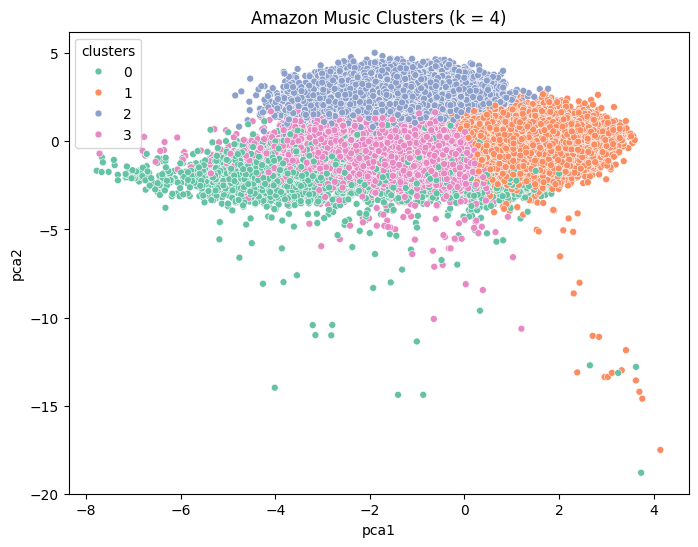

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='clusters',
    data=df,
    palette='Set2',
    s=25
)
plt.title("Amazon Music Clusters (k = 4)")
plt.show()


In [18]:
df_orig=pd.read_csv("single_genre_artists.csv")
df_orig["clusters"]=df["clusters"]

In [22]:
#Explode genres (since songs often have multiple genres)
df_genres = df_orig[["clusters", "genres"]].copy()
df_genres["genres"] = df_genres["genres"].str.split(',')
df_genres = df_genres.explode("genres")
df_genres["genres"] = df_genres["genres"].str.strip()

In [24]:
#Genre frequency per cluster
genre_cluster_dist = (
    df_genres
    .groupby(["clusters", "genres"])
    .size()
    .reset_index(name="count")
    .sort_values(["clusters", "count"], ascending=[True, False])
)


In [25]:
top_genres = genre_cluster_dist.groupby("clusters").head(5)
top_genres

,clusters,genres,count
476,0,['classic soundtrack'],368
1166,0,['sleep'],170
432,0,['classic bollywood'],169
84,0,'jazz fusion',147
994,0,['new orleans jazz'],146
3147,1,['j-pop'],771
4336,1,[],732
4216,1,['turkish pop'],586
3848,1,['rock uruguayo'],497
2445,1,['classic thai pop'],469


In [26]:
# Top artists per cluster
top_artists = (
    df_orig.groupby(["clusters", "name_artists"])
      .size()
      .reset_index(name="count")
      .sort_values(["clusters", "count"], ascending=[True, False])
)

top_artists.groupby("clusters").head(5)

,clusters,name_artists,count
402,0,Charlie Chaplin,253
286,0,Bill Evans,143
1308,0,Louis Armstrong & His Hot Five,124
1029,0,Jan Johansson,77
1166,0,Khursheed Bano,76
5059,1,Die drei ???,273
2668,1,ARASHI,223
7913,1,Karibe con K,170
11705,1,S. P. Balasubrahmanyam,154
3900,1,Boney M.,142


In [27]:
df_orig.to_csv("amazon_music_clustered.csv", index=False)